In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from benchmark import benchmark
from scipy.optimize import fsolve,curve_fit
import seaborn as sns
#sns.set()
%matplotlib qt5
#import numba as nb
#from numba.experimental import jitclass

In [3]:
"""@jitclass({
            'q':nb.float64,
            'p':nb.float64,
            'x':nb.float64,
            'y':nb.float64,
            't':nb.float64,
            'H':nb.float64,
            'L':nb.float64
         })"""
class State:
    
    def __init__(self,q,p):
        self.q = np.asarray(q,dtype=np.float64)
        self.p = np.asarray(p,dtype=np.float64)
        self.x = np.array([self.q[0]])
        self.y = np.array([self.q[1]])
        self.px = np.array([self.p[0]])
        self.py = np.array([self.p[1]])
        self.t = np.array([0])
        self.H = np.array([self.Hamiltonian()])
        self.L = np.array([self.angularMomentum()])
        #self.A = np.array([self.LRL()])
        
    def showState(self):
        x,y = self.q
        #fig,ax = plt.subplots()
        #ax.set_aspect(1)
        plt.scatter([0,x],[0,y])
        plt.xlim(-abs(x)*1.1,abs(x)*1.1)
        plt.ylim(-abs(y)*1.1,abs(y)*1.1)
        plt.show()
        
    def showTrace(self,marker='b-'):
        fig,ax = plt.subplots(figsize=(8,8))
        ax.set_aspect(1)
        plt.plot(self.x,self.y,marker)
        plt.scatter([0],[0],color="red")
        plt.xlim(-np.max(np.abs(self.x))*1.1,np.max(np.abs(self.x))*1.1)
        plt.ylim(-np.max(np.abs(self.y))*1.1,np.max(np.abs(self.y))*1.1)
        plt.show()
        
    def showStats(self):
        if len(self.H) == 0:
            raise "No stats saved"
        fig,ax = plt.subplots(1,2,figsize=(8,6))
        ax[0].plot(self.t,self.H,'b-')
        ax[1].plot(self.t,self.L,'g-')
        plt.show()
    
    def qdot(self,p):
        return p
    
    def pdot(self,q):
        return -q/np.linalg.norm(q)**3
    
    def Hamiltonian(self):
        return 0.5*np.linalg.norm(self.p)**2-1/np.linalg.norm(self.q)
    
    def angularMomentum(self):
        return self.q[1]*self.p[0]-self.q[0]*self.p[1]
    
    def symplecticEulerStep(self,dt):
        self.q += dt*self.qdot(self.p)
        self.p += dt*self.pdot(self.q)
        
    def impTrapStep(self,dt):
        def hfunc(x):
            return np.array([x[0:2]-self.q-0.5*dt*(self.qdot(self.p)+self.qdot(x[2:])), x[2:]-self.p-0.5*dt*(self.pdot(self.q)+self.pdot(x[:2]))]).ravel()
        x = np.array([self.q,self.p]).ravel()
        xnew = fsolve(hfunc,x)
        self.q = xnew[:2]
        self.p = xnew[2:]
    
    def explicitEulerStep(self,dt):
        q = self.q
        p = self.p
        self.q = q+dt*self.qdot(p)
        self.p = p+dt*self.pdot(q)
        
    def RK4Step(self,dt):
        q,p = self.q,self.p
        k1,l1 = self.qdot(p),self.pdot(q)
        k2,l2 = self.qdot(p+0.5*dt*l1),self.pdot(q+0.5*dt*k1)
        k3,l3 = self.qdot(p+0.5*dt*l2),self.pdot(q+0.5*dt*k2)
        k4,l4 = self.qdot(p+dt*l3),self.pdot(q+dt*k3)
        self.q += dt/6*(k1+2*k2+2*k3+k4)
        self.p += dt/6*(l1+2*l2+2*l3+l4)
        
    def symmetricRuthStep(self,dt):
        b = [7/48,3/8,-1/48,-1/48,3/8,7/48]
        bhat = [1/3,-1/3,1,-1/3,1/3,0]
        n = len(b)
        for i in range(n):
            self.p += b[i]*dt*self.pdot(self.q)
            self.q += bhat[i]*dt*self.qdot(self.p)
            
    def GaussLegendreStep(self,dt): #nöd ready!!
        A = [[1/4,1/4-np.sqrt(3)/6],[1/4+np.sqrt(3)/6]]
        b = [1/2,1/2]
        x0 = np.array([self.q,self.p],dtype=float)
        def f(x):
            return np.array([self.qdot(x[2:]),self.pdot(x[:2])],dtype=float)
        def kfunc(k):
            return np.array([k[0]-f(x0+dt*A[0][0]*k[0]+dt*A[0][1]*k[1]),k[1]-f(x0+dt*A[1][0]*k[0]+dt*A[1][1]*k[1])])
        k = fsolve(kfunc,np.ones((2,2,2)))
        x1 = x0+dt*b[0]*k[0]+dt*b[1]*k[1]
        self.q,self.p = x[:2],x[2:]
    
    def evolve(self,dt,Tmax,saveStats=True,saveNthStep=False,solver=None):
        t = 0
        if saveNthStep==False:
            saveNthStep = 1
        if solver==None:
            solver = self.symmetricRuthStep
        if saveStats:
            while t<Tmax:
                for i in range(saveNthStep):
                    solver(dt)
                    t += dt
                self.x = np.append(self.x,self.q[0])
                self.y = np.append(self.y,self.q[1])
                self.px = np.append(self.px,self.p[0])
                self.py = np.append(self.py,self.p[1])
                self.t = np.append(self.t,t)
                self.H = np.append(self.H,self.Hamiltonian())
                self.L = np.append(self.L,self.angularMomentum())
             
            #print(f"Stepsize is {dt}, done {int(Tmax/dt)} steps and saved {int(Tmax/dt/saveNthStep)} of them at steps of {dt*saveNthStep}")
            return self.t,self.x,self.y,self.H,self.L
        
        else:
            while t<Tmax:
                solver(dt)
            return
                
    def getFunction(self):
        xfun = interp1d(self.t,self.x,kind="cubic")
        yfun = interp1d(self.t,self.y,kind="cubic")
        return xfun,yfun
    
s = State(q0,p0)
for i in range(10):
    s.impTrapStep(0.1)
    #print(s.q)

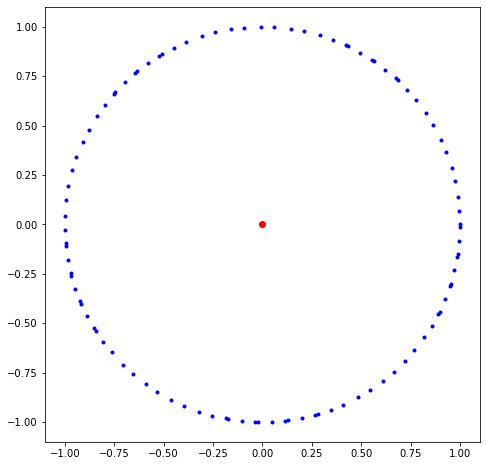

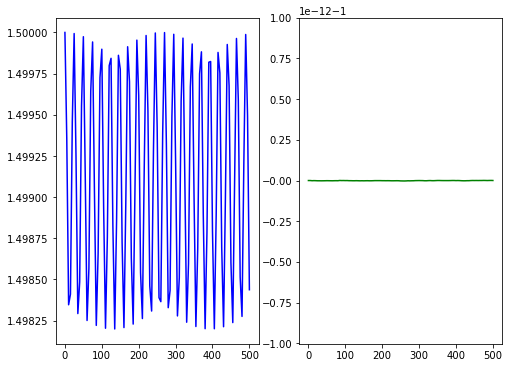

In [103]:
s = State([1,0],[0,1])
s.evolve(0.5,500,True,10)#,solver=s.symplecticEulerStep)
s.showTrace('b.')
s.showStats()

In [6]:
t = np.linspace(0,20,100)
plt.plot(s.t,s.x)
plt.plot(t,s.getFunction()[0](t),'b:')

ValueError: The number of derivatives at boundaries does not match: expected 3, got 0+0

In [3]:
q0 = [1,0]
p0 = [0,1.35]
dt = 0.77
T = 800 #1 revolution ca 84 #800
N = 1

s = State(q0,p0)
t1,x1,y1,h1,l1 = s.evolve(dt,T,True,N,solver=s.symmetricRuthStep)
s = State(q0,p0)
t2,x2,y2,h2,l2 = s.evolve(dt/4,T,True,4*N,solver=s.symplecticEulerStep)
s = State(q0,p0)
t3,x3,y3,h3,l3 = s.evolve(dt/1.5,T,True,int(1.5*N),solver=s.RK4Step)
s = State(q0,p0)
t4,x4,y4,h4,l4 = s.evolve(dt/500,T,True,500*N,solver=s.explicitEulerStep)
s = State(q0,p0)
t5,x5,y5,h5,l5 = s.evolve(dt/4,T,True,4*N,solver=s.impTrapStep)

In [14]:
"""fig,ax = plt.subplots(figsize=(8,8))
ax.set_aspect(1)
plt.plot([0],[0],'ro')
plt.plot(x1,y1,'-',label="Symmetric Ruth",color="blue")
plt.plot(x2,y2,'-',label="Symplectic Euler",color="green",alpha=0.7)
plt.plot(x3,y3,'-',label="Runge-Kutta 4",color="purple",alpha=0.7)
plt.plot(x4,y4,'-',label="Explicit Euler",color="brown",alpha=0.7)
plt.plot(x5,y5,'-',label="implicid Trapezoid",color="slategrey",alpha=0.7)
plt.legend()
fig,ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0,500)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\mathcal{H}$ (line)")
plt.plot(t1,h1,'-',label="Symmetric Ruth",color="blue",lw=0.99)
plt.plot(t2,h2,'-',label="Symplectic Euler",color="green",alpha=0.7,lw=0.99)
plt.plot(t3,h3,'-',label="Runge-Kutta 4",color="purple",alpha=0.7,lw=0.99)
plt.plot(t4,h4,'-',label="Explicit Euler",color="brown",alpha=0.7,lw=0.99)
plt.plot(t5,h5,'-',label="implizid Trapezoid",color="slategrey",alpha=0.7,lw=0.99)
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel(r"$L$ (dotted)")
plt.plot(t1,l1,':',label="Symmetric Ruth",color="blue",alpha=0.99)
plt.plot(t2,l2,':',label="Symplectic Euler",color="green",alpha=0.99)
plt.plot(t3,l3,':',label="Runge-Kutta 4",color="purple",alpha=0.99)
plt.plot(t4,l4,':',label="Explicit Euler",color="brown",alpha=0.99)
plt.plot(t5,l5,':',label="implicid Trapezoid",color="slategrey",alpha=0.99)
#plt.legend()"""

fig,ax = plt.subplots(figsize=(8,8))
ax.set_aspect(1)
plt.plot([0],[0],'ro')
plt.plot(x1,y1,'-',label="Symmetric Ruth",color="blue")
plt.plot(x2,y2,'-',label="Symplectic Euler",color="green",alpha=0.7)
plt.plot(x3,y3,'-',label="Runge-Kutta 4",color="purple",alpha=0.7)
plt.plot(x4,y4,'-',label="Explicit Euler",color="brown",alpha=0.7)
#plt.plot(x5,y5,'-',label="implicit trapezoid",color="slategrey",alpha=0.7)
plt.legend(loc="lower left")
fig,ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0,500)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\mathcal{H}$ (line)")
plt.plot(t1,1e3*abs(h1-h1[0]),'-',label="Symmetric Ruth",color="blue",lw=0.99)
plt.plot(t2,1e3*abs(h2-h1[0]),'-',label="Symplectic Euler",color="green",alpha=0.7,lw=0.99)
plt.plot(t3,1e3*abs(h3-h1[0]),'-',label="Runge-Kutta 4",color="purple",alpha=0.7,lw=0.99)
plt.plot(t4,1e3*abs(h4-h1[0]),'-',label="Explicit Euler",color="brown",alpha=0.7,lw=0.99)
#plt.plot(t5,1e3*abs(h5-h1[0]),'-',label="implizit trapezoid",color="slategrey",alpha=0.7,lw=0.99)
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel(r"$L$ (dotted)")
plt.plot(t1,1e3*abs(l1-l1[0]),':',label="Symmetric Ruth",color="blue",alpha=0.99)
plt.plot(t2,1e3*abs(l2-l1[0]),':',label="Symplectic Euler",color="green",alpha=0.99)
plt.plot(t3,1e3*abs(l3-l1[0]),':',label="Runge-Kutta 4",color="purple",alpha=0.99)
plt.plot(t4,1e3*abs(l4-l1[0]),':',label="Explicit Euler",color="brown",alpha=0.99)
#plt.plot(t5,1e3*abs(l5-l1[0]),':',label="implicit trapezoid",color="slategrey",alpha=0.99)
#plt.legend()

In [5]:
q0 = [1,0]
p0 = [0,1]
dt = 1
T = 200 #1 revolution 2pi
N = 1

s = State(q0,p0)
t1,x1,y1,h1,l1 = s.evolve(dt,T,True,N,solver=s.symmetricRuthStep)
s = State(q0,p0)
t2,x2,y2,h2,l2 = s.evolve(dt/32,T,True,32*N,solver=s.symplecticEulerStep)
s = State(q0,p0)
t3,x3,y3,h3,l3 = s.evolve(dt/6,T,True,8*N,solver=s.RK4Step)
#s = State(q0,p0)
#t4,x4,y4,h4,l4 = s.evolve(dt/2000,T,True,2000*N,solver=s.explicitEulerStep)
s = State(q0,p0)
t5,x5,y5,h5,l5 = s.evolve(dt/4,T,True,4*N,solver=s.impTrapStep)

In [13]:
"""fig,ax = plt.subplots(figsize=(8,8))
ax.set_aspect(1)
plt.plot([0],[0],'ro')
plt.plot(x1,y1,'-',label="Symmetric Ruth",color="blue")
plt.plot(x2,y2,'-',label="Symplectic Euler",color="green",alpha=0.7)
plt.plot(x3,y3,'-',label="Runge-Kutta 4",color="purple",alpha=0.7)
#plt.plot(x4,y4,'-',label="Explicit Euler",color="brown",alpha=0.7)
plt.legend()
fig,ax = plt.subplots(figsize=(8,8))
#ax.set_xlim(0,500)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\mathcal{H}$ (line)")
plt.plot(t1,h1,'-',label="Symmetric Ruth",color="blue",lw=0.99)
plt.plot(t2,h2,'-',label="Symplectic Euler",color="green",alpha=0.7,lw=0.99)
plt.plot(t3,h3,'-',label="Runge-Kutta 4",color="purple",alpha=0.7,lw=0.99)
#plt.plot(t4,h4,'-',label="Explicit Euler",color="brown",alpha=0.7,lw=0.99)
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel(r"$L$ (dotted)")
plt.plot(0.5*(t1[1:]+t1[:-1]),l1[1:],':',label="Symmetric Ruth",color="blue",alpha=0.99)
plt.plot(t2,l2,':',label="Symplectic Euler",color="green",alpha=0.99)
plt.plot(t3,l3,':',label="Runge-Kutta 4",color="purple",alpha=0.99)
#plt.plot(t4,l4,':',label="Explicit Euler",color="brown",alpha=0.99)
#plt.legend()"""

fig,ax = plt.subplots(figsize=(8,8))
ax.set_aspect(1)
plt.plot([0],[0],'ro')
plt.plot(x1,y1,'-',label="Symmetric Ruth",color="blue")
plt.plot(x2,y2,'-',label="Symplectic Euler",color="green",alpha=0.7)
plt.plot(x3,y3,'-',label="Runge-Kutta 4",color="purple",alpha=0.7)
#plt.plot(x4,y4,'-',label="Explicit Euler",color="brown",alpha=0.7)
plt.plot(x5,y5,'-',label="Implicid Trapezoid",color="slategrey",alpha=0.7)
plt.legend()
fig,ax = plt.subplots(figsize=(8,8))
#ax.set_xlim(0,500)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"relative error $\mathcal{H}$ (line)")
plt.plot(t1,-1e0*abs(h1-h1[0])/h1[0],'-',label="Symmetric Ruth",color="blue",lw=0.99)
plt.plot(t2,-1e0*abs(h2-h1[0])/h1[0],'-',label="Symplectic Euler",color="green",alpha=0.7,lw=0.99)
plt.plot(t3,-1e0*abs(h3-h1[0])/h1[0],'-',label="Runge-Kutta 4",color="purple",alpha=0.7,lw=0.99)
#plt.plot(t4,-1e0*abs(h4-h1[0])/h1[0],'-',label="Explicit Euler",color="brown",alpha=0.7,lw=0.99)
plt.plot(t5,-1e0*abs(h5-h1[0])/h1[0],'-',label="Implicid Trapezoid",color="slategrey",alpha=0.7,lw=0.99)
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel(r"relative error $L$ [$10^{-3}$] (dotted)")
plt.plot(t1,-1e3*abs(l1-l1[0])/l1[0],':',label="Symmetric Ruth",color="blue",alpha=0.99)
plt.plot(t2,-1e3*abs(l2-l1[0])/l1[0],':',label="Symplectic Euler",color="green",alpha=0.99)
plt.plot(t3,-1e3*abs(l3-l1[0])/l1[0],':',label="Runge-Kutta 4",color="purple",alpha=0.99)
#plt.plot(t4,-1e3*abs(l4-l1[0])/l1[0],':',label="Explicit Euler",color="brown",alpha=0.99)
plt.plot(t5,-1e3*abs(l5-l1[0])/l1[0],':',label="Implicid Trapezoid",color="slategrey",alpha=0.99)
#plt.legend()

In [488]:
s = State(q0,p0)
benchmark(s.evolve,4,arguments=[0.8,T,True,N,s.symmetricRuthStep])
s = State(q0,p0)
benchmark(s.evolve,4,arguments=[0.2,T,True,N,s.symplecticEulerStep])
s = State(q0,p0)
benchmark(s.evolve,4,arguments=[0.5,T,True,N,s.RK4Step])
s = State(q0,p0)
benchmark(s.evolve,4,arguments=[0.0025,T,True,200,s.explicitEulerStep])

Function needed 1.84ms + (1.03ms +- 217.75us), ran 1+3860 times in  4 seconds
Function needed 2.15ms + (2.87ms +- 658.21us), ran 1+1391 times in  4 seconds
Function needed 1.35ms + (1.49ms +- 268.13us), ran 1+2676 times in  4 seconds
Function needed 29.48ms + (22.87ms +- 2.61ms), ran 1+174 times in  4 seconds


0.022870891395656543

Benchmark error

In [4]:
def f(x,p,q):
    return p*x**q

T = 2*np.pi
q0 = [1,0]
p0 = [0,1]
DT = np.arange(0,1,0.05)[1:]
err = np.zeros(len(DT))
for i,dt in enumerate(DT):
    s = State(q0,p0)
    t,x,y,_,_ = s.evolve(dt,T,True,False,s.explicitEulerStep)
    x0,y0 = np.cos(t),np.sin(t)
    err[i] = ((x-x0)**2+(y-y0)**2).mean()
    x,y = -np.log(DT),0.5*np.log(err)
    a,b = np.polyfit(x,y,1)
#plt.plot(x,a*x+b,'k:')
plt.plot(x,y,marker=".",ms=5,lw=0.5,label="explicit Euler")
print("explicit Euler:",a,b)
for i,dt in enumerate(DT):
    s = State(q0,p0)
    t,x,y,_,_ = s.evolve(dt,T,True,False,s.symplecticEulerStep)
    x0,y0 = np.cos(t),np.sin(t)
    err[i] = ((x-x0)**2+(y-y0)**2).mean()
    x,y = -np.log(DT),0.5*np.log(err)
    a,b = np.polyfit(x,y,1)
#plt.plot(x,a*x+b,'k:')
plt.plot(x,y,marker="*",ms=5,lw=0.5,label="symplectic Euler")
print("symplectic Euler:",a,b)
for i,dt in enumerate(DT):
    s = State(q0,p0)
    t,x,y,_,_ = s.evolve(dt,T,True,False,s.RK4Step)
    x0,y0 = np.cos(t),np.sin(t)
    err[i] = ((x-x0)**2+(y-y0)**2).mean()
    x,y = -np.log(DT),0.5*np.log(err)
    a,b = np.polyfit(x,y,1)
#plt.plot(x,a*x+b,'k:')
plt.plot(x,y,marker="s",ms=5,lw=0.5,label="Runge-Kutta 4")
print("RK4:",a,b)
for i,dt in enumerate(DT):
    s = State(q0,p0)
    t,x,y,_,_ = s.evolve(dt,T,True,False,s.symmetricRuthStep)
    x0,y0 = np.cos(t),np.sin(t)
    err[i] = ((x-x0)**2+(y-y0)**2).mean()
    x,y = -np.log(DT),0.5*np.log(err)
    a,b = np.polyfit(x,y,1)
#plt.plot(x,a*x+b,'k:')
plt.plot(x,y,marker="d",ms=5,lw=0.5,label="symmetric Ruth")
print("symmetric Ruth:",a,b)
for i,dt in enumerate(DT):
    s = State(q0,p0)
    t,x,y,_,_ = s.evolve(dt,T,True,False,s.impTrapStep)
    x0,y0 = np.cos(t),np.sin(t)
    err[i] = ((x-x0)**2+(y-y0)**2).mean()
    x,y = -np.log(DT),0.5*np.log(err)
    a,b = np.polyfit(x,y,1)
#plt.plot(x,a*x+b,'k:')
plt.plot(x,y,marker="^",ms=5,lw=0.5,label="implicit trapezoid")#,color="slategrey")
print("implicit trap:",a,b)

plt.xlabel(r"$-\log{(h)}$")
plt.ylabel(r"$\log{(\varepsilon})$")
plt.legend()
plt.show()

<ipython-input-4-9a84a5e3bc8d>:14: RuntimeWarning: divide by zero encountered in log
  x,y = -np.log(DT),0.5*np.log(err)


explicit Euler: -0.5123270638787457 1.5108155681020954
symplectic Euler: -1.2099013630903486 0.883183311710525
RK4: -4.591878599691542 -0.7264392008174582
symmetric Ruth: -3.9212421669625854 -3.0533511472934523
implicit trap: -1.9851979859789468 -1.2131551064606185


Benchmark runtime

In [5]:
T = 2*np.pi
q0 = [1,0]
p0 = [0,1]
DT = np.arange(0,1,0.05)[1:]
tau = np.zeros(len(DT))
runtime = 0.25
for i,dt in enumerate(DT):
    s = State(q0,p0)
    tau[i] = benchmark(s.evolve,runtime,arguments=[dt,T,True,1,s.explicitEulerStep],message=False)
plt.plot(-np.log(DT),np.log(tau),marker=".",ms=5,lw=0.5,label="explicit Euler")
for i,dt in enumerate(DT):
    s = State(q0,p0)
    tau[i] = benchmark(s.evolve,runtime,arguments=[dt,T,True,1,s.symplecticEulerStep],message=False)
plt.plot(-np.log(DT),np.log(tau),marker="*",ms=5,lw=0.5,label="symplectic Euler")
for i,dt in enumerate(DT):
    s = State(q0,p0)
    tau[i] = benchmark(s.evolve,runtime,arguments=[dt,T,True,1,s.RK4Step],message=False)
plt.plot(-np.log(DT),np.log(tau),marker="s",ms=5,lw=0.5,label="Runge-Kutta 4")
for i,dt in enumerate(DT):
    s = State(q0,p0)
    tau[i] = benchmark(s.evolve,runtime,arguments=[dt,T,True,1,s.symmetricRuthStep],message=False)
plt.plot(-np.log(DT),np.log(tau),marker="d",ms=5,lw=0.5,label="symmetric Ruth")
for i,dt in enumerate(DT):
    s = State(q0,p0)
    tau[i] = benchmark(s.evolve,runtime,arguments=[dt,T,True,1,s.impTrapStep],message=False)
plt.plot(-np.log(DT),np.log(tau),marker="^",ms=5,lw=0.5,label="implicit trapezoid")#,color="slategrey")

plt.xlabel(r"$-\log{(h)}$")
plt.ylabel(r"$\log{(\tau})$")
plt.legend()
plt.show()

/Users/justin/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [508]:
s = State(q0,p0)
tau1 = benchmark(s.evolve,1,arguments=[0.05,T,True,False,s.explicitEulerStep],message=True)
s = State(q0,p0)
tau2 = benchmark(s.evolve,1,arguments=[0.05,T,True,False,s.symmetricRuthStep],message=True)
tau2/tau1

Function needed 10.66ms + (8.44ms +- 1.12ms), ran 1+117 times in  1 seconds
Function needed 17.54ms + (15.15ms +- 2.67ms), ran 1+65 times in  1 seconds


1.7948066737889021

In [495]:
s = State(q0,p0)
benchmark(s.evolve,1,arguments=[0.8,T,True,1,s.symmetricRuthStep])

Function needed 1.99ms + (970.36us +- 419.23us), ran 1+1025 times in  1 seconds


0.0009703564062351134

In [139]:
q0 = [-2,-1]
p0 = [1,1]
s = State(q0,p0)
s.evolve(0.1,1*np.pi)
plt.figure()
plt.plot(s.t,s.x,label="x")
plt.plot(s.t,s.y,label="y")
plt.plot(s.t,s.px,label="px")
plt.plot(s.t,s.py,label="py")
plt.legend()
plt.figure()
d = np.sqrt(s.x**2+s.y**2)
plt.plot(s.t,s.px**2+s.py**2-2/d)
plt.plot(s.t,s.x*s.py-s.y*s.px)
plt.figure()
plt.plot(s.x,s.y)
#plt.figure()

In [140]:
r = np.sqrt(s.x**2+s.y**2)
phi = np.arctan2(s.y,s.x)
L = q0[0]*p0[1]-q0[1]*p0[0]
E = 0.5*(p0[0]**2+p0[1]**2)-1/np.sqrt(q0[0]**2+q0[1]**2)
p,e = L**2,np.sqrt(1+2*E*L**2)

In [141]:
plt.plot(r)
plt.plot(phi)

In [142]:
def rfunc(phi,alpha):
    return p/(1+e*np.cos(phi-alpha))

In [143]:
from scipy.optimize import curve_fit

In [144]:
[alpha],_ = curve_fit(rfunc,phi,r,p0=[0])
p,e,alpha

(1, 1.451059202444919, 0.11510318212527411)

In [145]:
relErr = np.abs(rfunc(phi,alpha)/r-1)
plt.plot(relErr)
np.mean(relErr)

2.032330999270917

In [146]:
plt.plot(rfunc(phi,alpha))
plt.plot(r)